# **Classification and cross-validation with sklearn**

We will implement ML methods to distinguish subjects with ASD from controls, based on brain features computed by means of the [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) segmentation software. A subsample of the large amount of features generated by Freesurfer for the [ABIDE I](http://fcon_1000.projects.nitrc.org/indi/abide/) data cohort is analyzed.  

We will use  [pandas](https://pandas.pydata.org/) and at [sklearn](https://scikit-learn.org/stable/). Both the libraries are already installed on Colab. For some operation it will be necessary to convert the pandas DataFrame in a Numpy array. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC  # Support Vector Classification

# Read the dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_file = "/content/drive/MyDrive/Colab Notebooks/test/FS_features_ABIDE_males_someGlobals.csv"
# check and modify the path of the FS_features_ABIDE_males_someGlobals.csv file you downloaded in your drive
df = pd.read_csv(dataset_file)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FILE_ID,AGE_AT_SCAN,SEX,FIQ,DX_GROUP,lh_MeanThickness,rh_MeanThickness,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,TotalGrayVol
0,Caltech_0051456,55.4,1,126.0,1,2.52039,2.52379,258703.4443,262670.1207,262254.9768,265741.1295,701211.5651
1,Caltech_0051457,22.9,1,107.0,1,2.55533,2.56998,321132.1284,317004.7945,304528.2513,301555.0187,841485.9229
2,Caltech_0051458,39.2,1,93.0,1,2.64518,2.63160,266418.9917,266456.1701,271683.1723,266494.7088,726728.1619
3,Caltech_0051459,22.8,1,106.0,1,2.70814,2.72762,307157.4469,310540.0389,258618.7918,255480.2694,794676.4859
4,Caltech_0051461,37.7,1,99.0,1,2.59002,2.61012,263932.5269,269417.2519,242330.5838,232809.9268,714122.7788


As in previous example, we add a column with the *Site* information (we can derive it from the *FILE_ID*)

In [ ]:
df['Site'] = df['FILE_ID'].apply(lambda x: x.split('_')[0])

In [ ]:
df.columns

Index(['FILE_ID', 'AGE_AT_SCAN', 'SEX', 'FIQ', 'DX_GROUP', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
       'Site'],
      dtype='object')

As in previous examples, we make the DX_GROUP column more readable. This time we add a column with the readable labels and we keep the numerical labels [-1,1] which can directly be used in the classifier training process.


In [ ]:
df['DX_GROUP_STR'] = df.DX_GROUP.apply(lambda x: 'Controls' if x==-1 else 'ASD')
df.head()

,FILE_ID,AGE_AT_SCAN,SEX,FIQ,DX_GROUP,lh_MeanThickness,rh_MeanThickness,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,TotalGrayVol,Site,DX_GROUP_STR
0,Caltech_0051456,55.4,1,126.0,1,2.52039,2.52379,258703.4443,262670.1207,262254.9768,265741.1295,701211.5651,Caltech,ASD
1,Caltech_0051457,22.9,1,107.0,1,2.55533,2.56998,321132.1284,317004.7945,304528.2513,301555.0187,841485.9229,Caltech,ASD
2,Caltech_0051458,39.2,1,93.0,1,2.64518,2.63160,266418.9917,266456.1701,271683.1723,266494.7088,726728.1619,Caltech,ASD
3,Caltech_0051459,22.8,1,106.0,1,2.70814,2.72762,307157.4469,310540.0389,258618.7918,255480.2694,794676.4859,Caltech,ASD
4,Caltech_0051461,37.7,1,99.0,1,2.59002,2.61012,263932.5269,269417.2519,242330.5838,232809.9268,714122.7788,Caltech,ASD


In [ ]:
print(df.DX_GROUP_STR.unique())
print(df.DX_GROUP.unique())

We can count the entries grouped by the diagnostic group

In [ ]:
df.groupby('DX_GROUP_STR')['Site'].count()

DX_GROUP_STR
ASD         451
Controls    464
Name: Site, dtype: int64

We have a comparable number of subjects in the two diagnostic categories, which is fine for training a classifier.

# Binary classification: ASD vs. control subjects

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
df.columns

Index(['FILE_ID', 'AGE_AT_SCAN', 'SEX', 'FIQ', 'DX_GROUP', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
       'Site', 'DX_GROUP_STR'],
      dtype='object')

We can select a set of features we suppose to be relevant for the diagnostic group prediction.

In [ ]:
features = ['AGE_AT_SCAN', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
       ]

We split the data sample in the train and test subsets  

In [ ]:
train_set, test_set = train_test_split(df, test_size = 0.3)

In [ ]:
train_set[features]

,AGE_AT_SCAN,lh_MeanThickness,rh_MeanThickness,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,TotalGrayVol
74,11.3300,2.71229,2.71385,319579.1323,322009.7908,238765.9552,238870.2866,833006.9231
245,22.9900,2.69892,2.64420,289492.6096,294604.7206,243882.1644,248922.7498,783055.3302
879,10.6700,2.66038,2.64685,273943.8944,276339.6297,206084.3591,211487.3974,719064.5241
309,16.5500,2.62971,2.58312,287758.8055,287148.6961,259862.1371,261993.4356,750504.5016
316,29.0200,2.33333,2.34196,212090.9510,212231.9757,228207.4938,228949.1923,602763.9267
...,...,...,...,...,...,...,...,...
534,12.4298,2.51784,2.45189,232778.2901,219457.2935,182025.6691,177541.8561,619033.5835
382,15.0000,2.68388,2.61687,298635.0728,293862.2026,242320.9141,241006.8926,793279.2754
880,12.2500,2.55735,2.65263,267552.6615,276602.5415,229376.3151,230660.1325,733610.2030
24,17.0000,2.78398,2.79103,277575.3709,278087.5801,211577.4327,210058.5522,729331.9510


In [ ]:
classifier = SVC(kernel='linear', probability=True)
classifier = classifier.fit(StandardScaler().fit_transform(train_set[features]), train_set['DX_GROUP'])
classifier

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

We can compute the classification accuracy

In [ ]:
classifier.score(StandardScaler().fit_transform(test_set[features]), test_set['DX_GROUP'])

0.5745454545454546

## k-fold cross Validation 

In training a ML model, data should be partitioned in train and test set. The k-fold Cross Validation (CV) scheme provides a robust estimate of the performance and its associated error. Usually k=5 or k=10 is implemented, depending on the dataset size and on the available computing resources.

We have to import the model, preprocessing and metric functions from the sklearn libraries.
For some operations it will be necessary to convert the pandas DataFrame in a Numpy array. 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import numpy as np
from numpy import interp
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

As we did before, we select the features we will use as predictors


In [ ]:
features = ['AGE_AT_SCAN', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
]

As the features (i.e. volume and thickness measures) are in different ranges of values, we rescale them column-wise to have all them in the same range. We can apply a z-score transform, *i.e. with the sklearn.StandardScaler* or other normalization transforms, e.g the *sklearn.RobustScaler*, which removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). 

In [ ]:
X, y = df[features], df['DX_GROUP']
# X = StandardScaler().fit_transform(X)

We define a function which implements the k-fold CV, computes and averages the AUC values over the folds and provides plots of the ROC curve.

In [ ]:
def plot_cv_roc(X, y, classifier, n_splits=5, scaler=None):
  """
  plot_cv_roc trains the classifier on X data with y labels, implements the
  k-fold-CV with k=n_splits, may implement a feature scaling function.
  It plots the ROC curves for each k fold and their average and displays 
  the corresponding AUC values and the standard deviation over the k folders.
  """
  if scaler:
    model = Pipeline([('scaler', scaler()),
                    ('classifier', classifier)])
  else:
    model = classifier

  try:
    y = y.to_numpy()
    X = X.to_numpy()
  except AttributeError:
    pass
    
  cv = StratifiedKFold(n_splits)

  tprs = [] #True positive rate
  aucs = [] #Area under the ROC Curve
  interp_fpr = np.linspace(0, 1, 100)
  plt.figure()
  i = 0
  for train, test in cv.split(X, y):
    probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
#      print(f"{fpr} - {tpr} - {thresholds}\n")
    interp_tpr = interp(interp_fpr, fpr, tpr)
    tprs.append(interp_tpr)
    
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    i += 1
  plt.legend()
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.show()

  plt.figure()
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(interp_fpr, mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(interp_fpr, mean_tpr, color='b',
          label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate',fontsize=18)
  plt.ylabel('True Positive Rate',fontsize=18)
  plt.title('Cross-Validation ROC of SVM',fontsize=18)
  plt.legend(loc="lower right", prop={'size': 15})
  plt.show()

*It's ok! We've just defined a function, no output is expected*

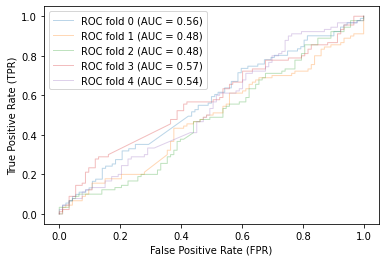

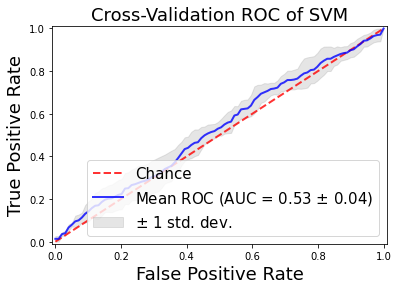

In [ ]:
classifier = SVC(kernel='linear', probability=True)
plot_cv_roc(X,y, classifier, 5, scaler=RobustScaler)

## Exploring datasample subsets 

If we are convinced that the heterogeneity introduced by the wide age range is excessive, we can reduce the number of subjects according to a predefined age range.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


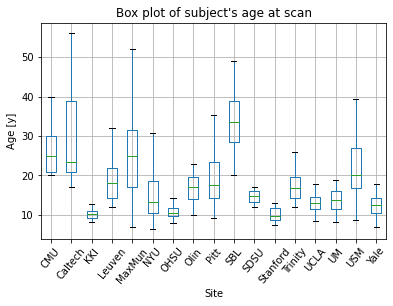

In [ ]:
boxplot = df.boxplot(column='AGE_AT_SCAN', by='Site', showfliers=False)
boxplot.set_title('Box plot of subject\'s age at scan')
boxplot.get_figure().suptitle('');
boxplot.set_ylabel('Age [y]')

boxplot.set_xticklabels(labels=boxplot.get_xticklabels(), rotation=50);

### Age < threshold

In [ ]:
features = ['AGE_AT_SCAN', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
]

In [ ]:
reduced_df = df[df.AGE_AT_SCAN<20]
X, y = reduced_df[features], reduced_df['DX_GROUP']

In [ ]:
df.shape, X.shape 

((915, 14), (661, 8))

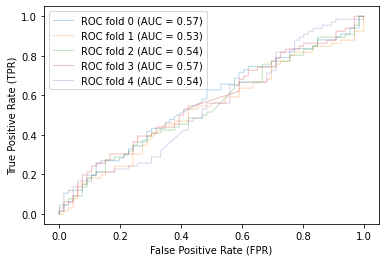

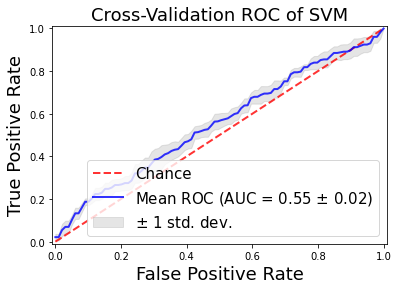

In [ ]:
classifier = SVC(kernel='linear', probability=True)
plot_cv_roc(X,y, classifier, 5, scaler=RobustScaler)

### Similar sites
We can explore a subset of sites with similar age characteristics

In [ ]:
selected_sites = df[(df['Site'] == 'KKI') | (df['Site'] == 'Stanford') | (df['Site'] == 'UCLA')]
X, y = selected_sites[features], selected_sites['DX_GROUP']
df.shape, X.shape

((915, 14), (157, 8))

In [ ]:
selected_sites.groupby(['DX_GROUP_STR','Site'])['FILE_ID'].count()

DX_GROUP_STR  Site    
ASD           KKI         18
              Stanford    15
              UCLA        46
Controls      KKI         24
              Stanford    15
              UCLA        39
Name: FILE_ID, dtype: int64

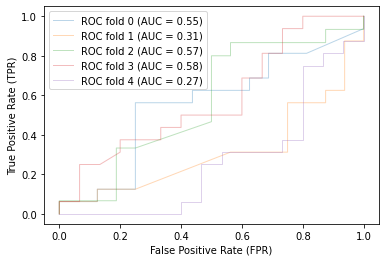

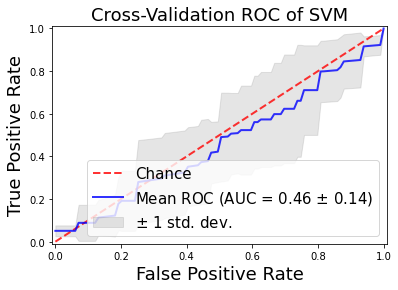

In [ ]:
classifier = SVC(kernel='linear', probability=True)
plot_cv_roc(X,y, classifier, 5, scaler=RobustScaler)

A classifier trained on data from site A which learnt to distinguish a subject's category according to a confounding variable, will not work on data from site B.




# Binary classification: Site A vs. site B 


Let's see whether the Site information is a confounding variable for ASD vs. Control classification. We evaluate the classification performance in site A vs. site B classification.

The first thing we need to do is selecting the dataframe rows which are related to two different sites, e.g. KKI and Stanford.

In [ ]:
two_sites = df[(df['Site'] == 'KKI') | (df['Site'] == 'Stanford')]

two_sites.tail()

,FILE_ID,AGE_AT_SCAN,SEX,FIQ,DX_GROUP,lh_MeanThickness,rh_MeanThickness,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,TotalGrayVol,Site,DX_GROUP_STR
532,Stanford_0051195,11.1780,1,110.0,-1,2.44935,2.42373,199652.3505,192268.9690,185546.5570,178815.0037,560968.3194,Stanford,Controls
533,Stanford_0051196,11.8816,1,117.0,-1,2.52832,2.56226,237062.9734,237355.4508,198392.2610,192152.2541,649456.4242,Stanford,Controls
534,Stanford_0051197,12.4298,1,113.0,-1,2.51784,2.45189,232778.2901,219457.2935,182025.6691,177541.8561,619033.5835,Stanford,Controls
535,Stanford_0051198,12.2546,1,114.0,-1,2.62927,2.63808,252567.2433,259348.2309,189513.6820,191944.8318,698247.4743,Stanford,Controls
536,Stanford_0051199,12.3833,1,125.0,-1,2.56885,2.49018,185434.2572,187366.2479,153018.8091,159041.5279,562545.5051,Stanford,Controls


In [ ]:
features = ['AGE_AT_SCAN', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
]

X = RobustScaler().fit_transform(two_sites[features])
y = two_sites['Site'].apply(lambda x: 1 if x=='KKI' else -1)

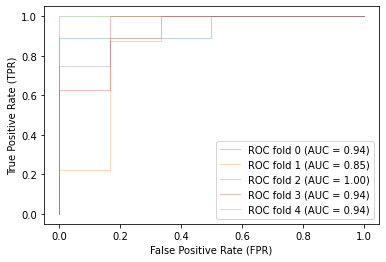

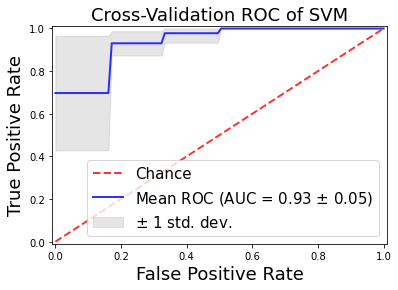

In [ ]:
classifier = SVC(kernel='linear', probability=True, random_state=1)
plot_cv_roc(X, y, classifier, 5, scaler=RobustScaler)

# Accounting for confounders into the analysis 

To mitigate the effect of the different acquisition sites on the features, we have to harmonize data across sites. We can attempt to normalize them by applying, for example, a per-site feature normalization (*sklearn.RobustScaler*).

In [ ]:
df_site1 = df[df.Site == 'KKI']
df_site2 = df[df.Site == 'Stanford']
df_site3 = df[df.Site == 'UCLA']

In [ ]:
features = ['AGE_AT_SCAN', 'lh_MeanThickness',
       'rh_MeanThickness', 'lhCortexVol', 'rhCortexVol',
       'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'TotalGrayVol',
]

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
X_site1 = RobustScaler().fit_transform(df_site1[features])
X_site2 = RobustScaler().fit_transform(df_site2[features])
X_site3 = RobustScaler().fit_transform(df_site3[features])

In [ ]:
X = np.concatenate((X_site1, X_site2, X_site3))
y = np.concatenate((df_site1['DX_GROUP'], df_site2['DX_GROUP'], df_site3['DX_GROUP']))

In [ ]:
X.shape

(157, 8)

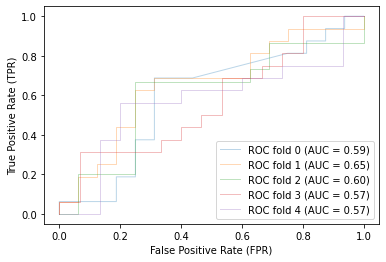

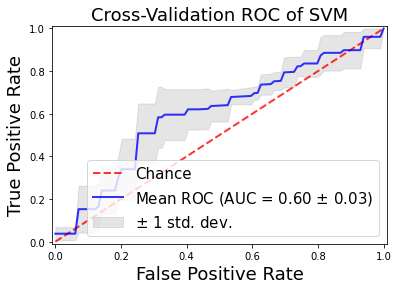

In [ ]:
classifier = SVC(kernel='linear', probability=True)
plot_cv_roc(X, y, classifier, 5)

# Conclusions
If we obtain good/bad discrimination performance between two different diagnostic classes, are we sure the classifier is exploiting the right descriptive features?

To know more about how to evaluate the effect of confounding variables in your data you can read the recent paper by Ferrari E, *et al.*, [*Dealing with confounders and outliers in classification medical studies: the Autism Spectrum Disorders case study*](https://www.sciencedirect.com/science/article/pii/S0933365719306086), Artif Intell Med 2020, 108, 101926. doi: 10.1016/j.artmed.2020.101926 